In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import librosa
import math
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
import h5py

In [ ]:
def load_data(dataset_path):
    hf = h5py.File(dataset_path, 'r')
    inputs = hf.get('inputs')
    targets = hf.get('targets')
    
    inputs = np.array(inputs)
    targets = np.array(targets)
    hf.close()
    
    return inputs, targets

In [ ]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(learning_rate=1e-4)

In [ ]:
from sklearn.preprocessing import StandardScaler

def prepare_dataset(test_size, validation_size):
    X,y = load_data(r"/content/drive/MyDrive/Thesis/Datasets/music_dataset_augmented.h5")
    print(f"X shape = {X.shape} y shape = {y.shape}")

    inputs_testing = X.reshape(-1, X.shape[-1])
    print(inputs_testing.shape)
    scaler = StandardScaler()
    X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    print(f"Inputs = {X.shape}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = validation_size)

    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    print(X_val.shape, y_val.shape)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.2, 0.5)

X shape = (39944, 130, 13) y shape = (39944,)
(5192720, 13)
Inputs = (39944, 130, 13)
(31955, 130, 13, 1) (31955,)
(3994, 130, 13, 1) (3994,)
(3995, 130, 13, 1) (3995,)


In [ ]:
input_shape = X_train.shape[1:]
print(input_shape)

(130, 13, 1)


In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 64)        256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                        

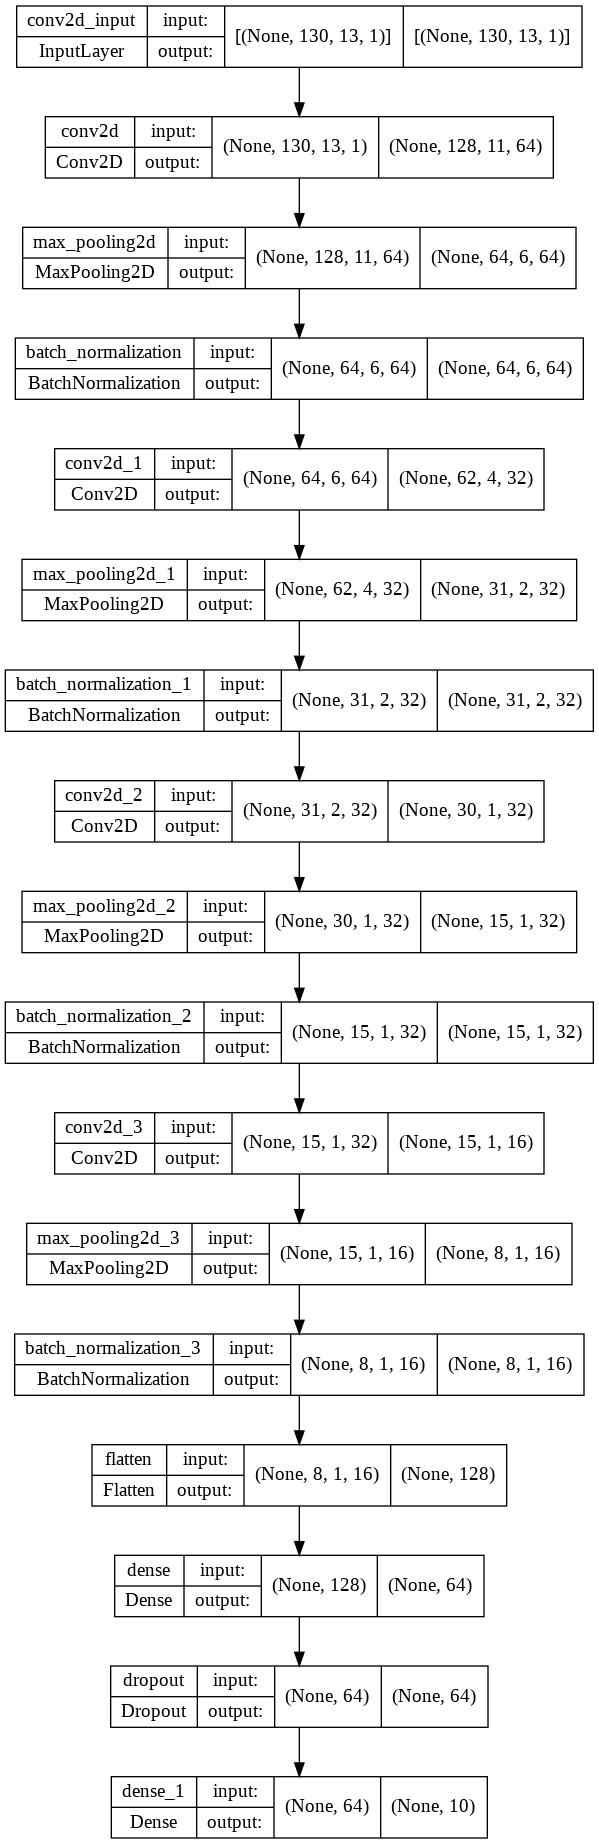

In [ ]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, show_shapes=True, show_layer_names=True, to_file='/content/drive/MyDrive/Thesis/Models/cnn_model_plot.png')#, to_file='/content/drive/MyDrive/Thesis/Models/cnn_model_plot.png'

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.compile(optimizer=adam, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

hist = model.fit (
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 60,
    batch_size = 32,
    # callbacks = callbacks
)

Epoch 1/60
999/999 [==============================] - 20s 10ms/step - loss: 2.2675 - sparse_categorical_accuracy: 0.2172 - val_loss: 1.8691 - val_sparse_categorical_accuracy: 0.3109
Epoch 2/60
999/999 [==============================] - 9s 9ms/step - loss: 1.8851 - sparse_categorical_accuracy: 0.3209 - val_loss: 1.6581 - val_sparse_categorical_accuracy: 0.4030
Epoch 3/60
999/999 [==============================] - 9s 9ms/step - loss: 1.7355 - sparse_categorical_accuracy: 0.3665 - val_loss: 1.5467 - val_sparse_categorical_accuracy: 0.4403
Epoch 4/60
999/999 [==============================] - 9s 9ms/step - loss: 1.6354 - sparse_categorical_accuracy: 0.4028 - val_loss: 1.4635 - val_sparse_categorical_accuracy: 0.4608
Epoch 5/60
999/999 [==============================] - 9s 9ms/step - loss: 1.5531 - sparse_categorical_accuracy: 0.4367 - val_loss: 1.3877 - val_sparse_categorical_accuracy: 0.5074
Epoch 6/60
999/999 [==============================] - 9s 9ms/step - loss: 1.4842 - sparse_categori

In [ ]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

125/125 [==============================] - 1s 5ms/step - loss: 0.9294 - sparse_categorical_accuracy: 0.6870
Test accuracy: 0.687030553817749


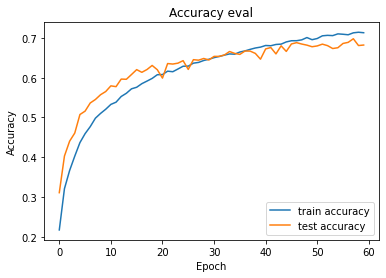

In [ ]:
plt.plot(hist.history["sparse_categorical_accuracy"], label="train accuracy")
plt.plot(hist.history["val_sparse_categorical_accuracy"], label="test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy eval")
plt.show()

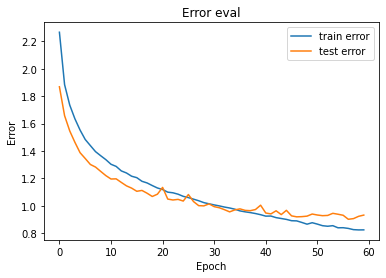

In [ ]:
plt.plot(hist.history["loss"], label="train error")
plt.plot(hist.history["val_loss"], label="test error")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(loc="upper right")
plt.title("Error eval")
plt.show()

In [ ]:
def predict(model, X, y):
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")

In [ ]:
predict(model, X_test[6], y_test[6])

Expected index: 1, Predicted index: [1]


In [ ]:
model.save('/content/drive/MyDrive/Thesis/Models/CNN_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Thesis/Models/CNN_model/assets


In [ ]:
import pickle
with open('/content/drive/MyDrive/Thesis/History/CNN_history.pkl', 'wb') as file_pi:
        pickle.dump(hist, file_pi)

INFO:tensorflow:Assets written to: ram://da0f6c4d-7018-46e6-8f4e-fc11ac545cf9/assets


In [ ]:
with open('/content/drive/MyDrive/Thesis/History/CNN_history.pkl', 'rb') as f:
    saved_model = pickle.load(f)

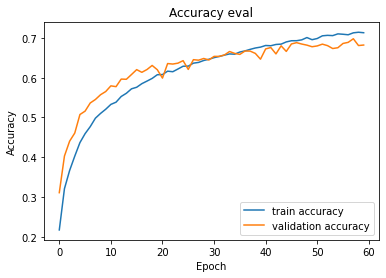

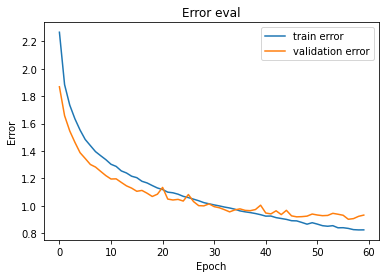

In [ ]:
plt.plot(saved_model.history["sparse_categorical_accuracy"], label="train accuracy")
plt.plot(saved_model.history["val_sparse_categorical_accuracy"], label="validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy eval")
plt.show()

plt.plot(saved_model.history["loss"], label="train error")
plt.plot(saved_model.history["val_loss"], label="validation error")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(loc="upper right")
plt.title("Error eval")
plt.show()